In [4]:
import os
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
from keras.optimizers import Adam, RMSprop
from keras.models import load_model
import sys
sys.path.append(r'C:\Users\HW\Desktop\Deep Learning\01Assignment\a3\src')
from data_preparation import StockIndexDataset
from rnn_models import *
from utils import plot_seqs, create_labels

In [5]:
# Set constant variables and hyper-parameters for the model training

INPUT_PATH = r"C:\Users\HW\Desktop\Deep Learning\01Assignment\a3\src\data"
OUTPUT_PATH = r'C:\Users\HW\Desktop\Deep Learning\01Assignment\a3\scr\models' 
os.makedirs(OUTPUT_PATH, exist_ok=True)
# Load datasets
datasets_path = [os.path.join(INPUT_PATH, file) for file in sorted(os.listdir(INPUT_PATH))]
for p in datasets_path:
    print(p)

RNN_params = {"batch_size": 32,
              "epochs": 50,
              "lr": 1e-4,
              "time_steps": 30,
              "forecast_steps": 1,
              "window": 30,
              "RNN_size": 128,
              "FC_size": 32,
              "optim": Adam,
              "dropout": 0.5,
              "earlystop": {"patience": 20, 
                            "min_delta": 0.00001},
              "reduce_lr": {"factor": 0.1,
                            "patience": 10,
                            "min_delta": 0.0001}
              }

GRU_params = {"batch_size": 32,
              "epochs": 50,
              "lr": 1e-4,
              "time_steps": 30,
              "forecast_steps": 1,
              "window": 30,
              "RNN_size": 128,
              "FC_size": 32,
              "optim": Adam,
              "dropout": 0.5,
              "earlystop": {"patience": 20, 
                            "min_delta": 0.00001},
              "reduce_lr": {"factor": 0.1,
                            "patience": 10,
                            "min_delta": 0.0001}
              }

LSTM_params = {"batch_size": 32,
               "epochs": 50,
               "lr": 1e-4,
               "time_steps": 30,
               "forecast_steps": 1,
               "window": 30,
               "RNN_size": 128,
               "FC_size": 32,
               "optim": Adam,
               "dropout": 0.5,
               "earlystop": {"patience": 20, 
                             "min_delta": 0.00001},
               "reduce_lr": {"factor": 0.1,
                             "patience": 10,
                             "min_delta": 0.0001}
               }

def display_learningcurve(modelhist):
    df = pd.DataFrame(modelhist.history)

    # Display the first few rows
    print("DataFrame preview:")
    print(df.head())

    # Plot Loss
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.plot(df.index + 1, df['loss'], label='Training Loss')
    plt.plot(df.index + 1, df['val_loss'], label='Validation Loss')
    plt.title('Loss vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(df.index + 1, df['mda'], label='Training MDA')
    plt.plot(df.index + 1, df['val_mda'], label='Validation MDA')
    plt.title('Mean Directional Accuracy vs. Epochs')
    plt.xlabel('')
    plt.ylabel('Mean Directional Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

def trainRNN(datasets_path, params):
    data = StockIndexDataset(datasets_path, time_steps=params['time_steps'],
                            forecast_steps=params['forecast_steps'],
                            batch_size=params['batch_size'], val_ratio=.1, test_ratio=.1)
    data.info()
    
    input = (data.batch_size, data.time_steps, data.X_train.shape[2])
    model = build_SimpleRNN(input, params)
    filepath = os.path.join(OUTPUT_PATH, "RNN_bestweights.keras")
    callbacks = training_callbacks(['reduce_lr', 'mcp'], params,filepath) 
    hist = model.fit(data.X_train, data.y_train, 
                         epochs=params["epochs"], batch_size=data.batch_size,
                         shuffle=False, validation_data=(data.X_val, data.y_val), 
                         verbose=2, callbacks=callbacks)
    display_learningcurve(hist)

    predictions = ModelPredictions(model, 
                                    X = data.X, 
                                    y = data.y, 
                                    raw_y = data.raw_seq[:,1], 
                                    datetime = data.datetime,
                                    window = params['window'],
                                    batch_size = params['batch_size'])

    labels = ['Actual', 'Training', 'Validation', 'Test']
    predictions.plot_predictions(title="SH300IF (RNN model)", labels=labels)

    return predictions

def trainGRU(datasets_path, params):
    data = StockIndexDataset(datasets_path, time_steps=params['time_steps'],
                            forecast_steps=params['forecast_steps'],
                            batch_size=params['batch_size'], val_ratio=.1, test_ratio=.1)

    input = (data.batch_size, data.time_steps, data.X_train.shape[2])
    model = build_GRU(input, params)
    filepath = os.path.join(OUTPUT_PATH,"GRU_bestweights.keras") 
    callbacks = training_callbacks(['reduce_lr', 'mcp'], params,filepath) 
    hist = model.fit(data.X_train, data.y_train, 
                         epochs=params["epochs"], batch_size=data.batch_size,
                         shuffle=False, validation_data=(data.X_val, data.y_val), 
                         verbose=2, callbacks=callbacks)
    display_learningcurve(hist)
    predictions = ModelPredictions(model, 
                                    X = data.X, 
                                    y = data.y, 
                                    raw_y = data.raw_seq[:,1], 
                                    datetime = data.datetime,
                                    window = params['window'],
                                    batch_size = params['batch_size'])

    labels = ['Actual', 'Training', 'Validation', 'Test']
    predictions.plot_predictions(title="SH300IF (GRU model)", labels=labels)
    return predictions

def trainLSTM(datasets_path, params):
    data = StockIndexDataset(datasets_path, time_steps=params['time_steps'],
                            forecast_steps=params['forecast_steps'],
                            batch_size=params['batch_size'], val_ratio=.1, test_ratio=.1)
    data.info()

    input = (data.batch_size, data.time_steps, data.X_train.shape[2])
    model = build_LSTM(input, params)
    filepath = os.path.join(OUTPUT_PATH,"LSTM_bestweights.keras") 
    callbacks = training_callbacks(['reduce_lr', 'mcp'], params,filepath) 
    hist = model.fit(data.X_train, data.y_train, 
                         epochs=params["epochs"], batch_size=data.batch_size,
                         shuffle=False, validation_data=(data.X_val, data.y_val), 
                         verbose=2, callbacks=callbacks)
    display_learningcurve(hist)
    predictions = ModelPredictions(model, 
                                    X = data.X, 
                                    y = data.y, 
                                    raw_y = data.raw_seq[:,1], 
                                    datetime = data.datetime,
                                    window = params['window'],
                                    batch_size = params['batch_size'])

    labels = ['Actual', 'Training', 'Validation', 'Test']
    predictions.plot_predictions(title="SH300IF (LSTM model)", labels=labels)
    return predictions

C:\Users\HW\Desktop\Deep Learning\01Assignment\a3\src\data\2010.4.1-2012.12.31.txt
C:\Users\HW\Desktop\Deep Learning\01Assignment\a3\src\data\2013.1.4-2014.12.31.txt
C:\Users\HW\Desktop\Deep Learning\01Assignment\a3\src\data\2015-2017.txt
C:\Users\HW\Desktop\Deep Learning\01Assignment\a3\src\data\2017-2019.4.29.txt


Window: time step = 12, forecast step = 6, window = 12
Loading dataset... Ready for training.
Stock Index Code: SH300IF
Train Set Length: 26048
Validation Set Length: 2880
Test Set Length: 3200
Epoch 1/50

Epoch 1: val_loss improved from inf to 0.02446, saving model to C:\Users\HW\Desktop\Deep Learning\01Assignment\a3\scr\models\RNN_bestweights.keras
814/814 - 2s - 3ms/step - loss: 0.0441 - mda: 0.5283 - rmse: 0.1816 - val_loss: 0.0245 - val_mda: 0.6174 - val_rmse: 0.1400 - learning_rate: 1.0000e-04
Epoch 2/50

Epoch 2: val_loss improved from 0.02446 to 0.01129, saving model to C:\Users\HW\Desktop\Deep Learning\01Assignment\a3\scr\models\RNN_bestweights.keras
814/814 - 2s - 2ms/step - loss: 0.0181 - mda: 0.5426 - rmse: 0.1247 - val_loss: 0.0113 - val_mda: 0.6157 - val_rmse: 0.0958 - learning_rate: 1.0000e-04
Epoch 3/50

Epoch 3: val_loss improved from 0.01129 to 0.00487, saving model to C:\Users\HW\Desktop\Deep Learning\01Assignment\a3\scr\models\RNN_bestweights.keras
814/814 - 1s - 2m

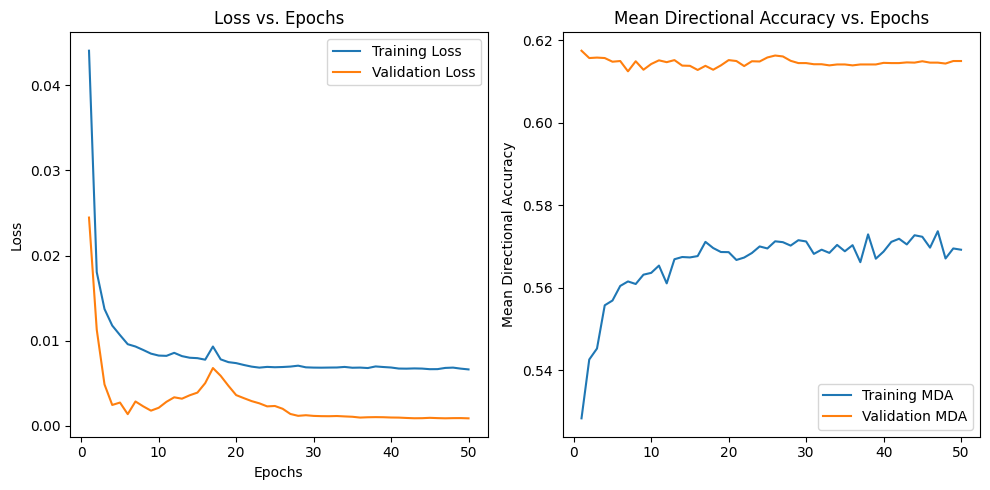

814/814 ━━━━━━━━━━━━━━━━━━━━ 1s 969us/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step


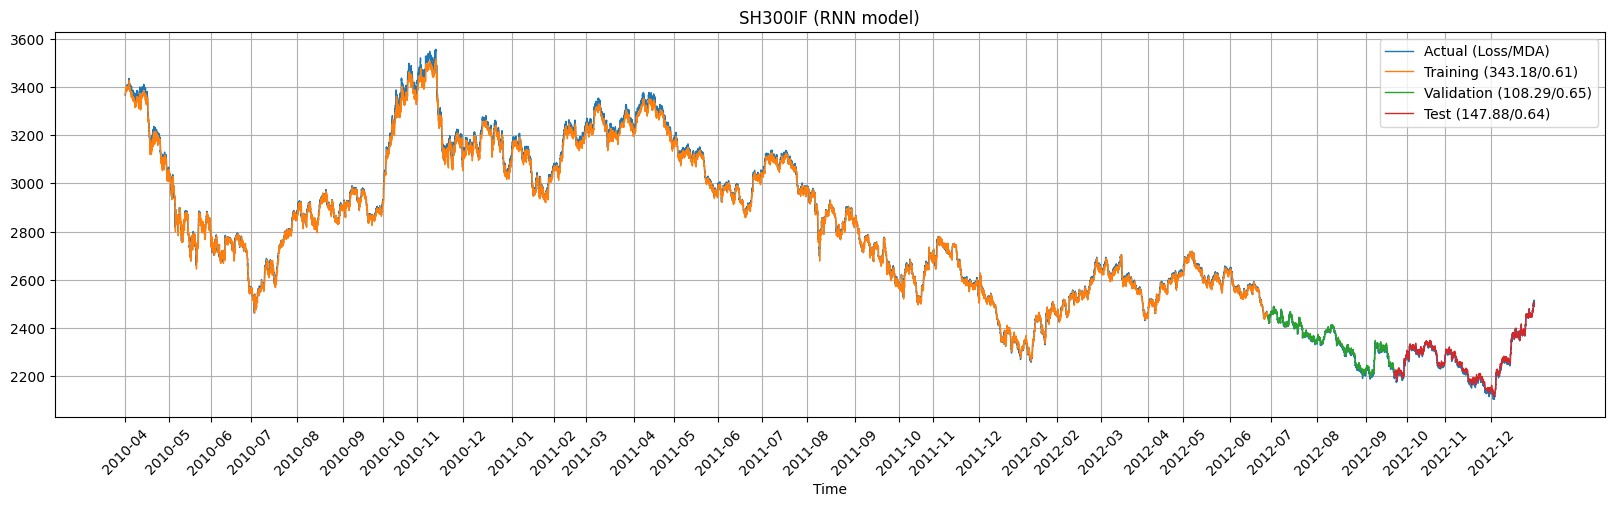

Loading dataset... Ready for training.
Epoch 1/50

Epoch 1: val_loss improved from inf to 0.00909, saving model to C:\Users\HW\Desktop\Deep Learning\01Assignment\a3\scr\models\GRU_bestweights.keras
814/814 - 6s - 7ms/step - loss: 0.1978 - mda: 0.5291 - rmse: 0.2688 - val_loss: 0.0091 - val_mda: 0.6083 - val_rmse: 0.0930 - learning_rate: 1.0000e-04
Epoch 2/50

Epoch 2: val_loss did not improve from 0.00909
814/814 - 3s - 4ms/step - loss: 0.0229 - mda: 0.5409 - rmse: 0.1344 - val_loss: 0.0097 - val_mda: 0.6079 - val_rmse: 0.0958 - learning_rate: 1.0000e-04
Epoch 3/50

Epoch 3: val_loss did not improve from 0.00909
814/814 - 4s - 4ms/step - loss: 0.0166 - mda: 0.5490 - rmse: 0.1166 - val_loss: 0.0103 - val_mda: 0.6082 - val_rmse: 0.0988 - learning_rate: 1.0000e-04
Epoch 4/50

Epoch 4: val_loss improved from 0.00909 to 0.00856, saving model to C:\Users\HW\Desktop\Deep Learning\01Assignment\a3\scr\models\GRU_bestweights.keras
814/814 - 4s - 4ms/step - loss: 0.0139 - mda: 0.5502 - rmse: 0.10

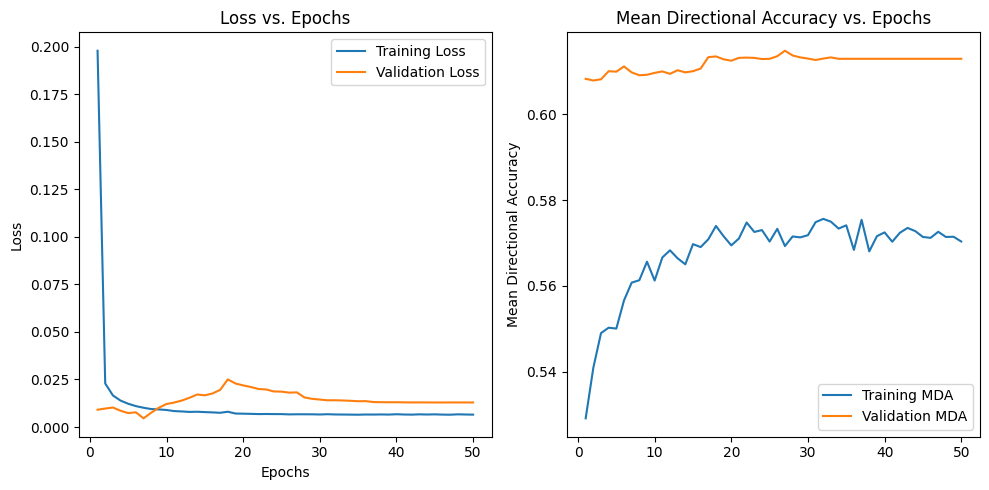

814/814 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


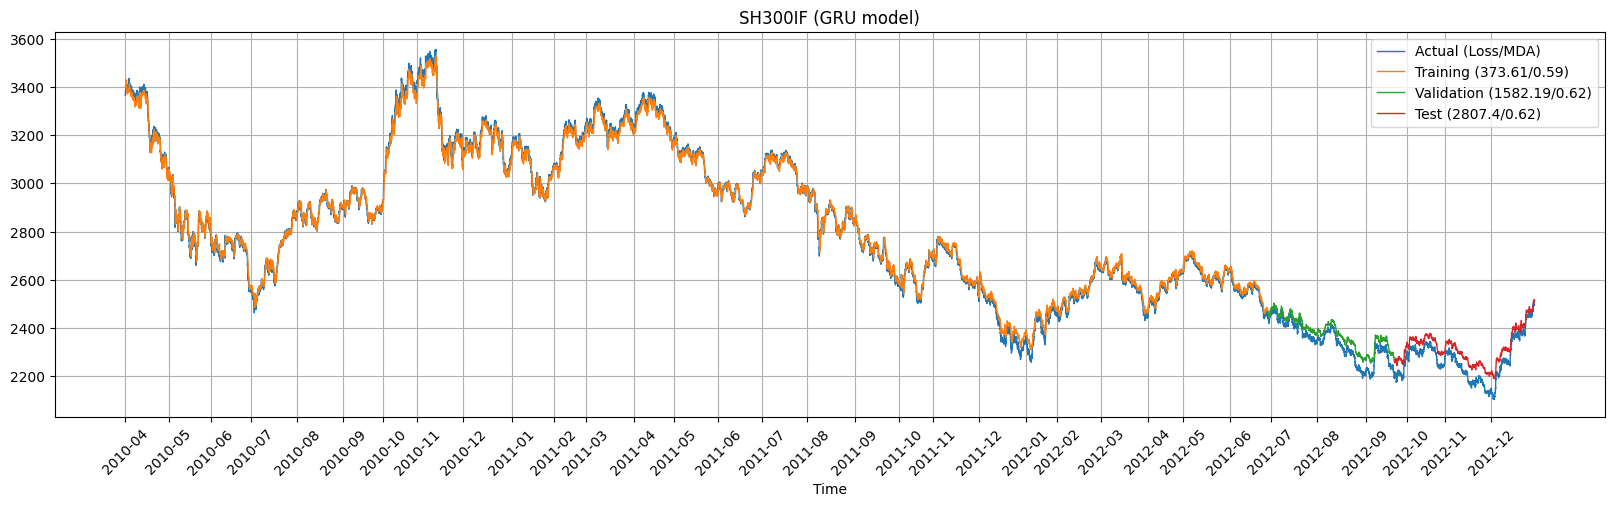

Loading dataset... Ready for training.
Stock Index Code: SH300IF
Train Set Length: 26048
Validation Set Length: 2880
Test Set Length: 3200
Epoch 1/50

Epoch 1: val_loss improved from inf to 0.03610, saving model to C:\Users\HW\Desktop\Deep Learning\01Assignment\a3\scr\models\LSTM_bestweights.keras
814/814 - 5s - 6ms/step - loss: 0.0912 - mda: 0.5194 - rmse: 0.1941 - val_loss: 0.0361 - val_mda: 0.6091 - val_rmse: 0.1694 - learning_rate: 1.0000e-04
Epoch 2/50

Epoch 2: val_loss improved from 0.03610 to 0.01882, saving model to C:\Users\HW\Desktop\Deep Learning\01Assignment\a3\scr\models\LSTM_bestweights.keras
814/814 - 3s - 4ms/step - loss: 0.0192 - mda: 0.5341 - rmse: 0.1204 - val_loss: 0.0188 - val_mda: 0.6087 - val_rmse: 0.1230 - learning_rate: 1.0000e-04
Epoch 3/50

Epoch 3: val_loss improved from 0.01882 to 0.01104, saving model to C:\Users\HW\Desktop\Deep Learning\01Assignment\a3\scr\models\LSTM_bestweights.keras
814/814 - 4s - 4ms/step - loss: 0.0159 - mda: 0.5420 - rmse: 0.1114 -

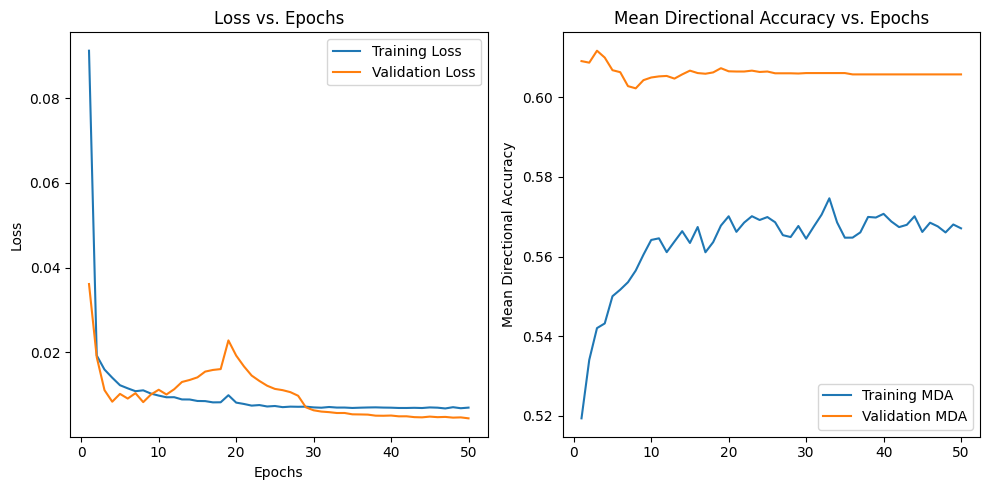

814/814 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


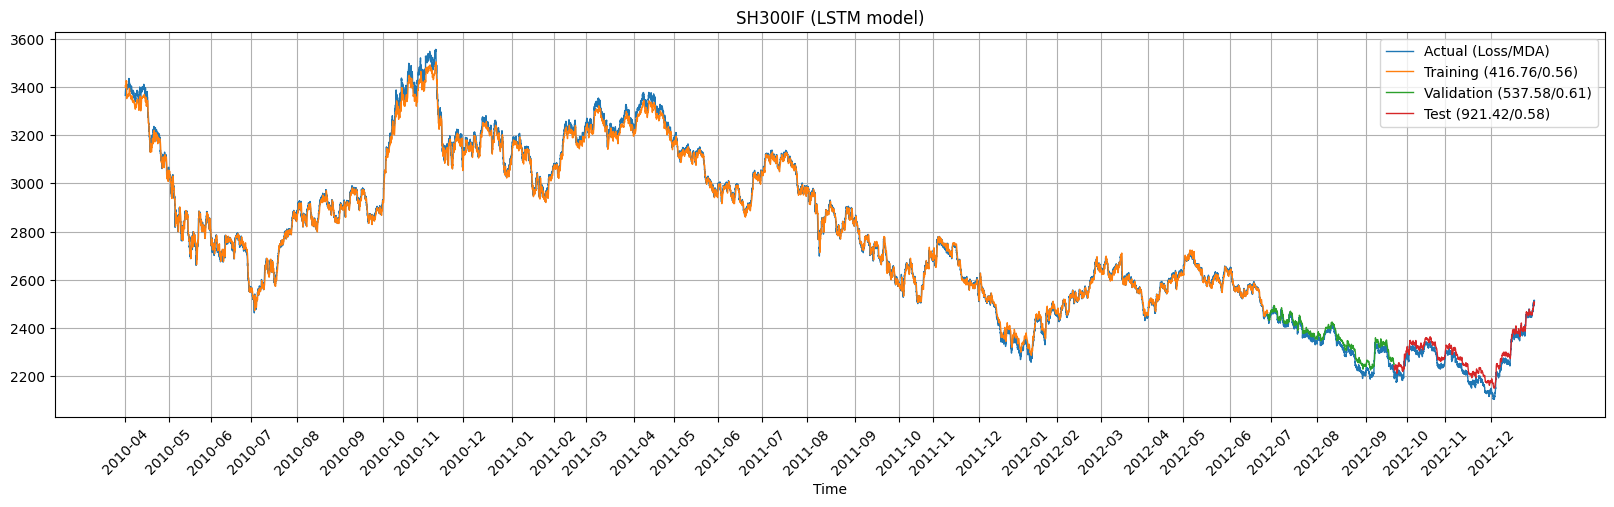

------------------------------------------------------------------------------------------------------

Window: time step = 12, forecast step = 1, window = 12
Loading dataset... Ready for training.
Stock Index Code: SH300IF
Train Set Length: 26048
Validation Set Length: 2880
Test Set Length: 3200
Epoch 1/50

Epoch 1: val_loss improved from inf to 0.00708, saving model to C:\Users\HW\Desktop\Deep Learning\01Assignment\a3\scr\models\RNN_bestweights.keras
814/814 - 3s - 4ms/step - loss: 0.0709 - mda: 0.5349 - rmse: 0.2088 - val_loss: 0.0071 - val_mda: 0.6314 - val_rmse: 0.0709 - learning_rate: 1.0000e-04
Epoch 2/50

Epoch 2: val_loss improved from 0.00708 to 0.00288, saving model to C:\Users\HW\Desktop\Deep Learning\01Assignment\a3\scr\models\RNN_bestweights.keras
814/814 - 2s - 2ms/step - loss: 0.0213 - mda: 0.5525 - rmse: 0.1353 - val_loss: 0.0029 - val_mda: 0.6364 - val_rmse: 0.0513 - learning_rate: 1.0000e-04
Epoch 3/50

Epoch 3: val_loss improved from 0.00288 to 0.00070, saving model

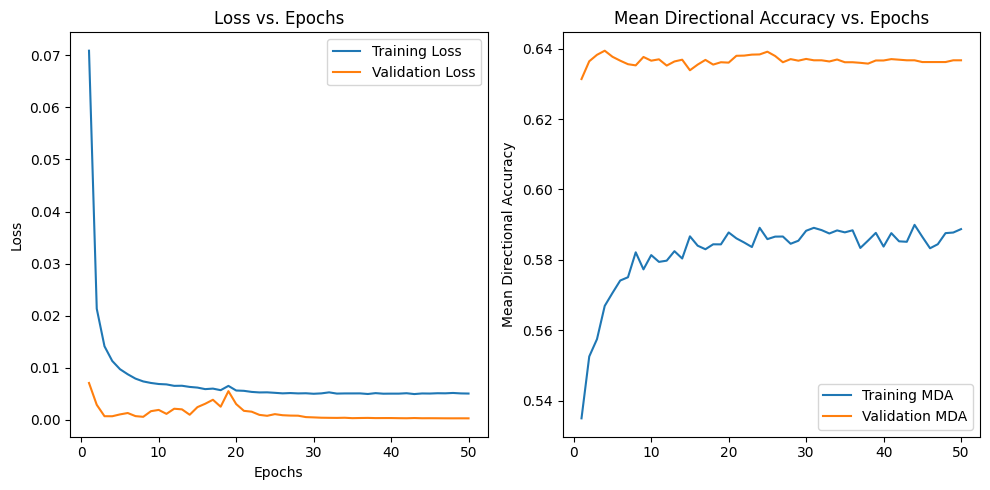

814/814 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


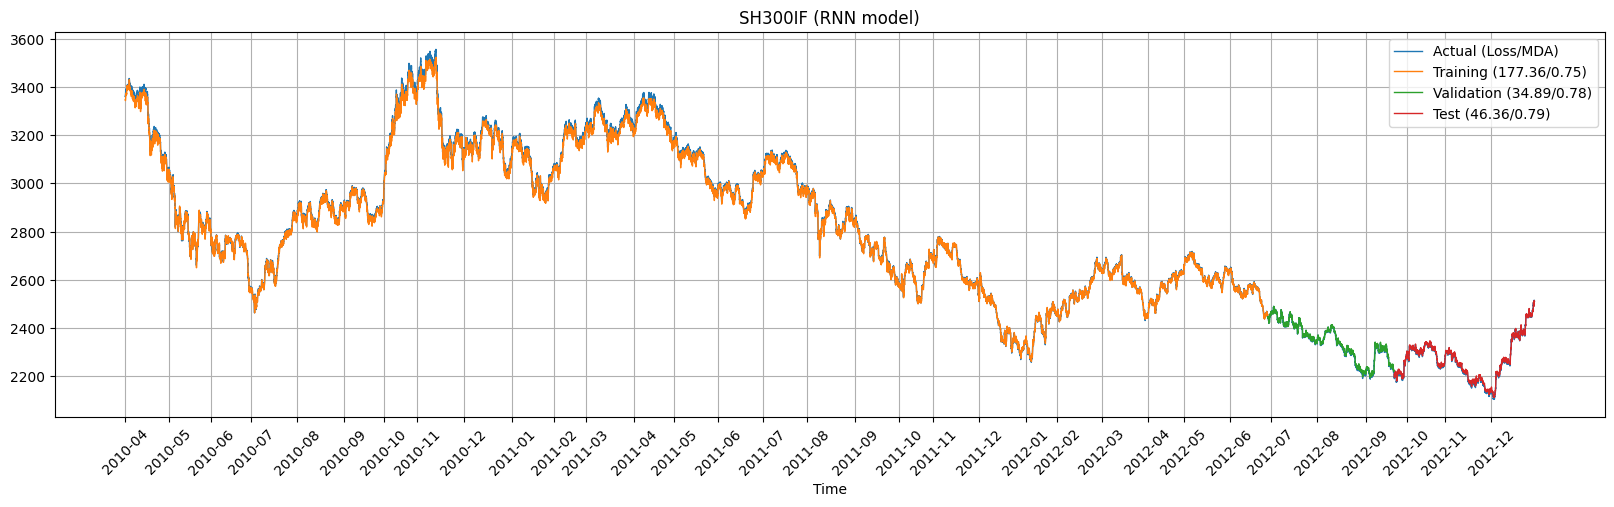

Loading dataset... Ready for training.
Epoch 1/50

Epoch 1: val_loss improved from inf to 0.03798, saving model to C:\Users\HW\Desktop\Deep Learning\01Assignment\a3\scr\models\GRU_bestweights.keras
814/814 - 7s - 9ms/step - loss: 0.0960 - mda: 0.5419 - rmse: 0.2155 - val_loss: 0.0380 - val_mda: 0.6461 - val_rmse: 0.1857 - learning_rate: 1.0000e-04
Epoch 2/50

Epoch 2: val_loss improved from 0.03798 to 0.01106, saving model to C:\Users\HW\Desktop\Deep Learning\01Assignment\a3\scr\models\GRU_bestweights.keras
814/814 - 5s - 6ms/step - loss: 0.0161 - mda: 0.5569 - rmse: 0.1192 - val_loss: 0.0111 - val_mda: 0.6457 - val_rmse: 0.1017 - learning_rate: 1.0000e-04
Epoch 3/50

Epoch 3: val_loss improved from 0.01106 to 0.00380, saving model to C:\Users\HW\Desktop\Deep Learning\01Assignment\a3\scr\models\GRU_bestweights.keras
814/814 - 5s - 6ms/step - loss: 0.0117 - mda: 0.5671 - rmse: 0.1041 - val_loss: 0.0038 - val_mda: 0.6443 - val_rmse: 0.0626 - learning_rate: 1.0000e-04
Epoch 4/50

Epoch 4:

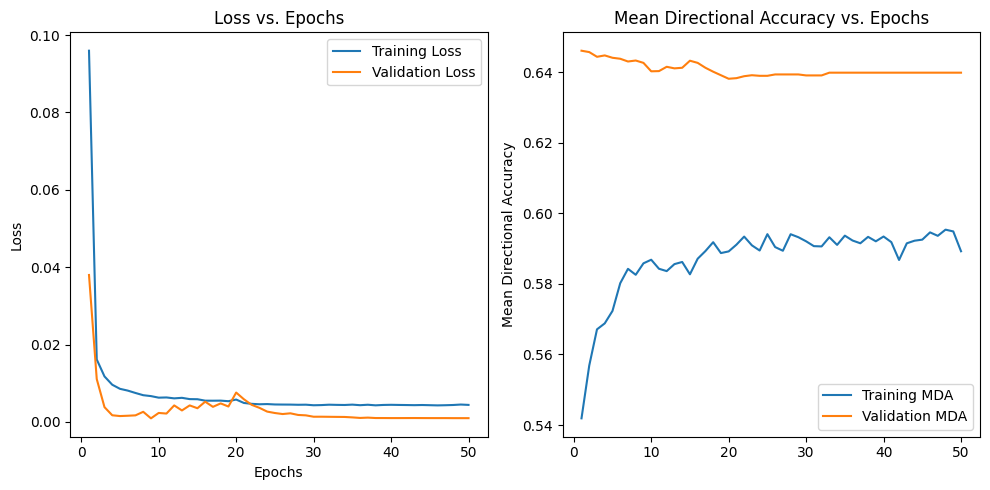

814/814 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


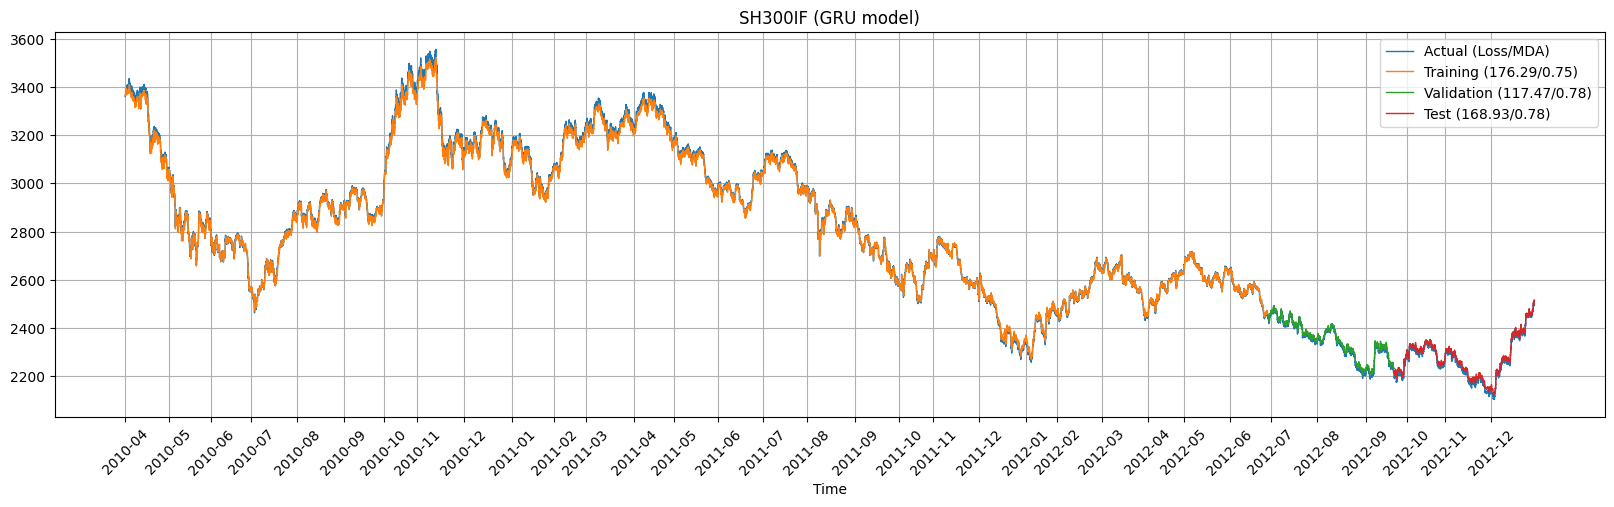

Loading dataset... Ready for training.
Stock Index Code: SH300IF
Train Set Length: 26048
Validation Set Length: 2880
Test Set Length: 3200
Epoch 1/50

Epoch 1: val_loss improved from inf to 0.02916, saving model to C:\Users\HW\Desktop\Deep Learning\01Assignment\a3\scr\models\LSTM_bestweights.keras
814/814 - 8s - 10ms/step - loss: 0.0797 - mda: 0.5341 - rmse: 0.1830 - val_loss: 0.0292 - val_mda: 0.6464 - val_rmse: 0.1527 - learning_rate: 1.0000e-04
Epoch 2/50

Epoch 2: val_loss improved from 0.02916 to 0.01061, saving model to C:\Users\HW\Desktop\Deep Learning\01Assignment\a3\scr\models\LSTM_bestweights.keras
814/814 - 5s - 6ms/step - loss: 0.0158 - mda: 0.5523 - rmse: 0.1127 - val_loss: 0.0106 - val_mda: 0.6472 - val_rmse: 0.0933 - learning_rate: 1.0000e-04
Epoch 3/50

Epoch 3: val_loss improved from 0.01061 to 0.00980, saving model to C:\Users\HW\Desktop\Deep Learning\01Assignment\a3\scr\models\LSTM_bestweights.keras
814/814 - 5s - 6ms/step - loss: 0.0122 - mda: 0.5620 - rmse: 0.1024 

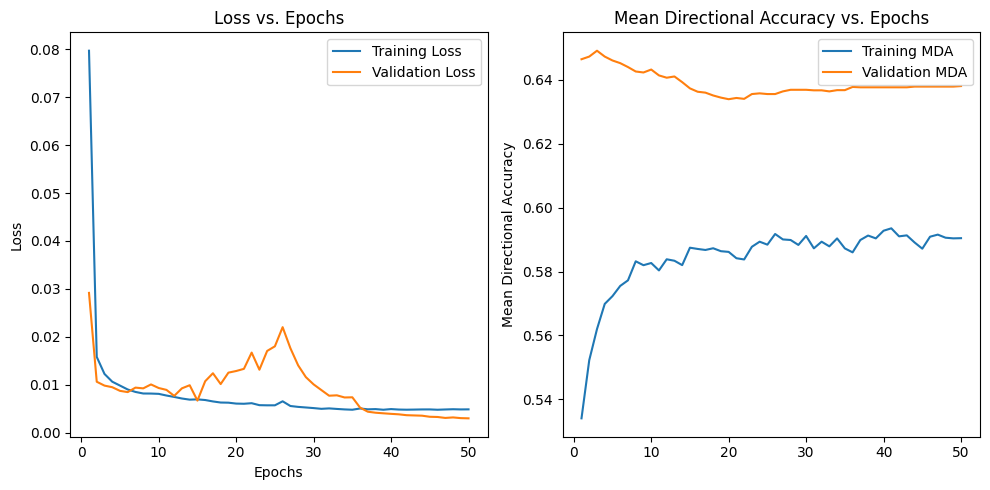

814/814 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


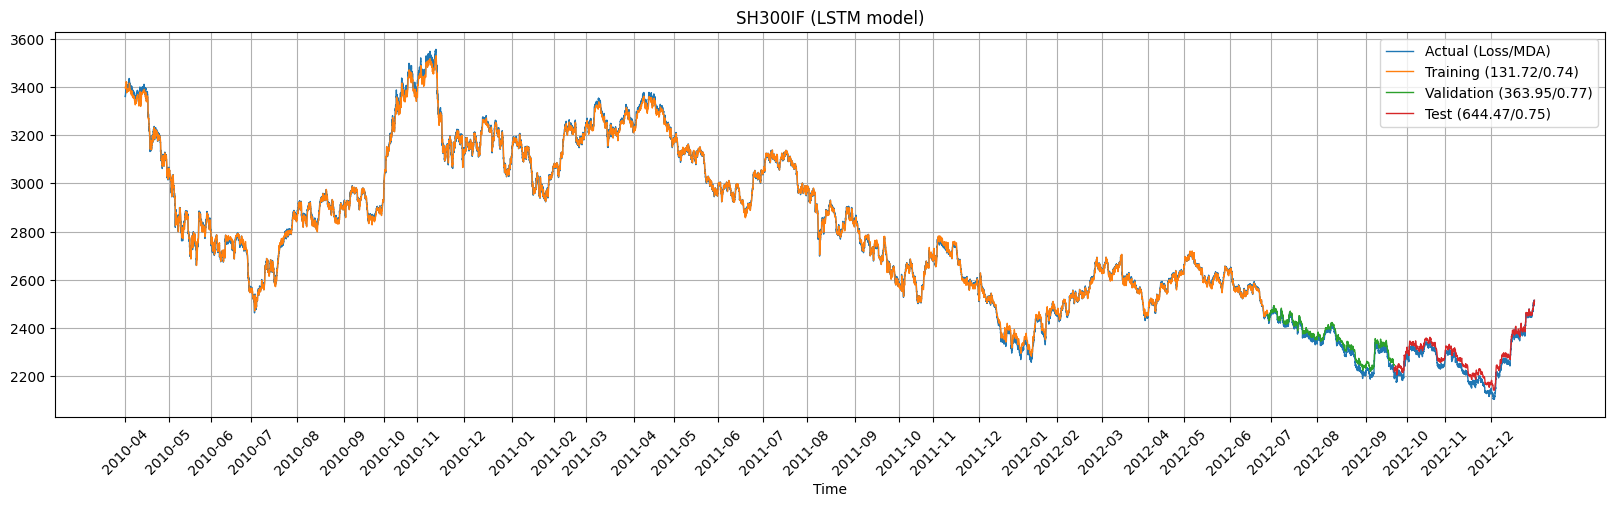

------------------------------------------------------------------------------------------------------

Window: time step = 36, forecast step = 1, window = 36
Loading dataset... Ready for training.
Stock Index Code: SH300IF
Train Set Length: 26048
Validation Set Length: 2880
Test Set Length: 3200
Epoch 1/50

Epoch 1: val_loss improved from inf to 0.00453, saving model to C:\Users\HW\Desktop\Deep Learning\01Assignment\a3\scr\models\RNN_bestweights.keras
814/814 - 6s - 7ms/step - loss: 0.0738 - mda: 0.5337 - rmse: 0.2112 - val_loss: 0.0045 - val_mda: 0.6466 - val_rmse: 0.0628 - learning_rate: 1.0000e-04
Epoch 2/50

Epoch 2: val_loss improved from 0.00453 to 0.00356, saving model to C:\Users\HW\Desktop\Deep Learning\01Assignment\a3\scr\models\RNN_bestweights.keras
814/814 - 5s - 6ms/step - loss: 0.0219 - mda: 0.5576 - rmse: 0.1350 - val_loss: 0.0036 - val_mda: 0.6488 - val_rmse: 0.0617 - learning_rate: 1.0000e-04
Epoch 3/50

Epoch 3: val_loss improved from 0.00356 to 0.00224, saving model

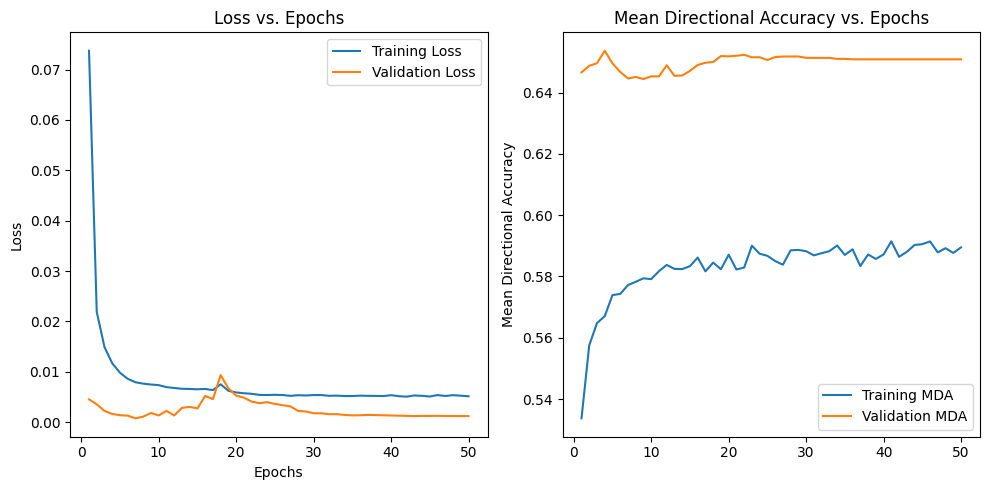

814/814 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


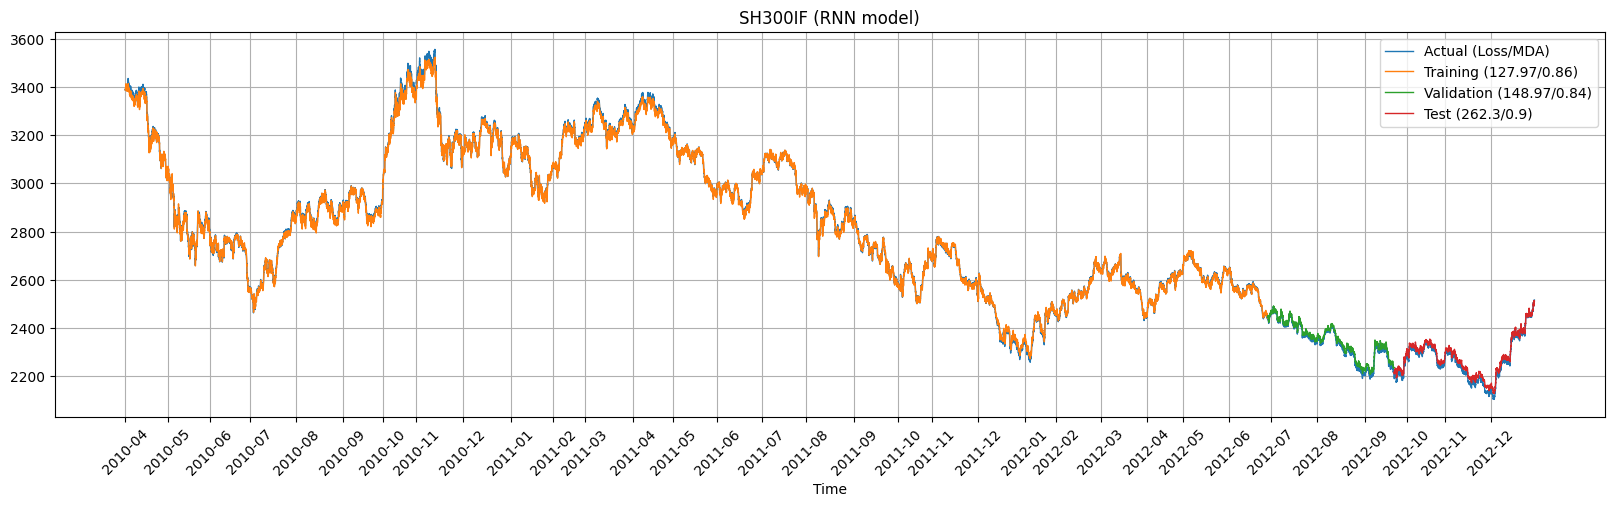

Loading dataset... Ready for training.
Epoch 1/50

Epoch 1: val_loss improved from inf to 0.00444, saving model to C:\Users\HW\Desktop\Deep Learning\01Assignment\a3\scr\models\GRU_bestweights.keras
814/814 - 23s - 29ms/step - loss: 0.0977 - mda: 0.5424 - rmse: 0.2062 - val_loss: 0.0044 - val_mda: 0.6568 - val_rmse: 0.0642 - learning_rate: 1.0000e-04
Epoch 2/50

Epoch 2: val_loss improved from 0.00444 to 0.00152, saving model to C:\Users\HW\Desktop\Deep Learning\01Assignment\a3\scr\models\GRU_bestweights.keras
814/814 - 16s - 19ms/step - loss: 0.0164 - mda: 0.5605 - rmse: 0.1180 - val_loss: 0.0015 - val_mda: 0.6557 - val_rmse: 0.0422 - learning_rate: 1.0000e-04
Epoch 3/50

Epoch 3: val_loss improved from 0.00152 to 0.00048, saving model to C:\Users\HW\Desktop\Deep Learning\01Assignment\a3\scr\models\GRU_bestweights.keras
814/814 - 14s - 17ms/step - loss: 0.0116 - mda: 0.5717 - rmse: 0.1026 - val_loss: 4.8065e-04 - val_mda: 0.6560 - val_rmse: 0.0299 - learning_rate: 1.0000e-04
Epoch 4/50

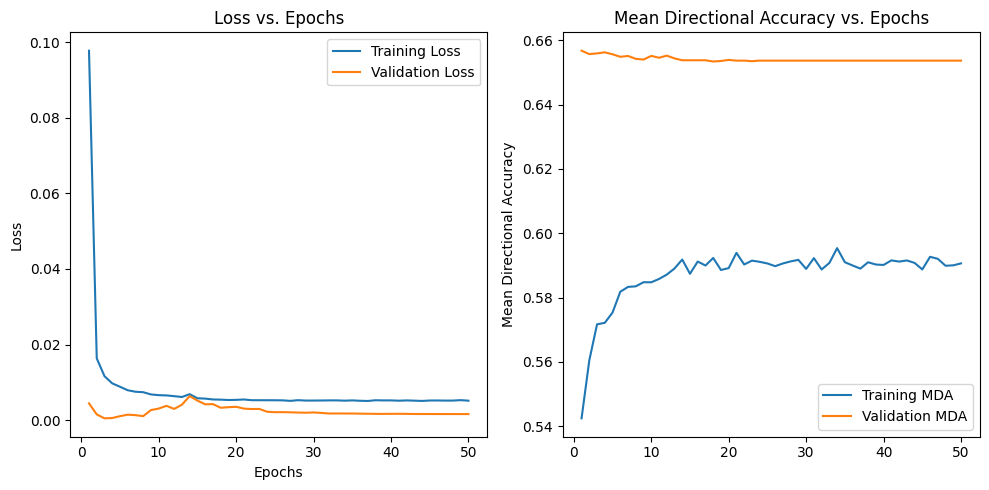

814/814 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step


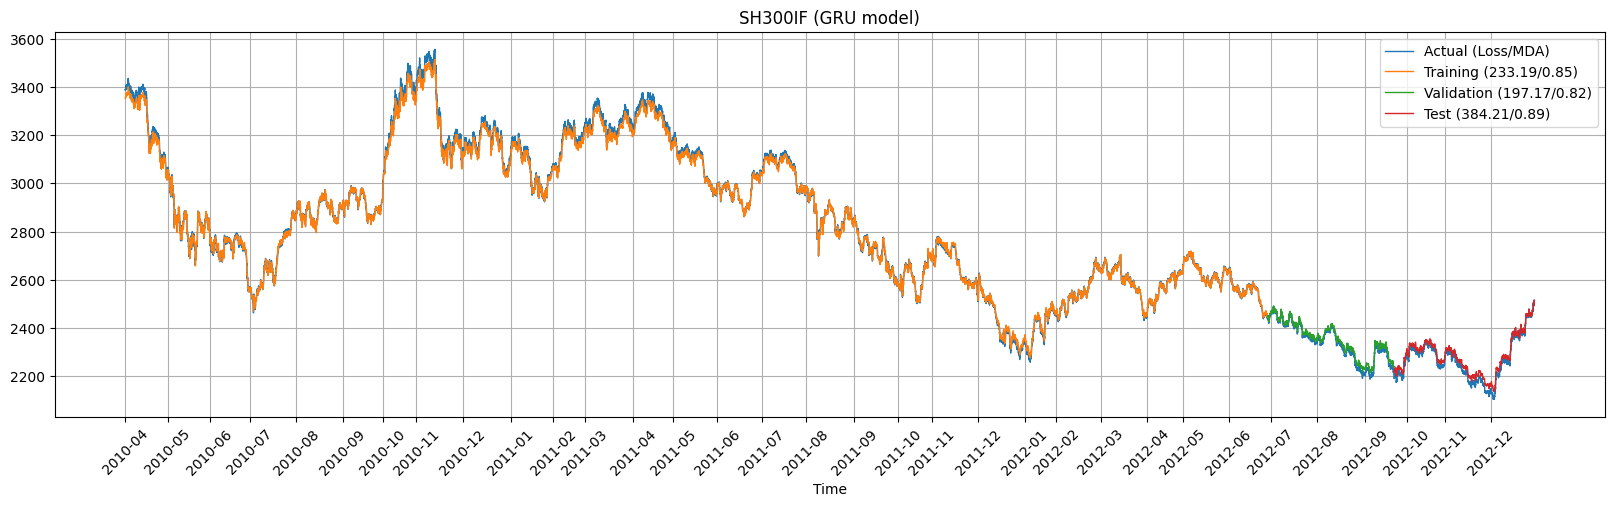

Loading dataset... Ready for training.
Stock Index Code: SH300IF
Train Set Length: 26048
Validation Set Length: 2880
Test Set Length: 3200
Epoch 1/50

Epoch 1: val_loss improved from inf to 0.02643, saving model to C:\Users\HW\Desktop\Deep Learning\01Assignment\a3\scr\models\LSTM_bestweights.keras
814/814 - 41s - 50ms/step - loss: 0.0816 - mda: 0.5328 - rmse: 0.1897 - val_loss: 0.0264 - val_mda: 0.6381 - val_rmse: 0.1418 - learning_rate: 1.0000e-04
Epoch 2/50

Epoch 2: val_loss improved from 0.02643 to 0.00513, saving model to C:\Users\HW\Desktop\Deep Learning\01Assignment\a3\scr\models\LSTM_bestweights.keras
814/814 - 32s - 40ms/step - loss: 0.0141 - mda: 0.5576 - rmse: 0.1090 - val_loss: 0.0051 - val_mda: 0.6393 - val_rmse: 0.0646 - learning_rate: 1.0000e-04
Epoch 3/50

Epoch 3: val_loss improved from 0.00513 to 0.00293, saving model to C:\Users\HW\Desktop\Deep Learning\01Assignment\a3\scr\models\LSTM_bestweights.keras
814/814 - 42s - 52ms/step - loss: 0.0111 - mda: 0.5647 - rmse: 0.

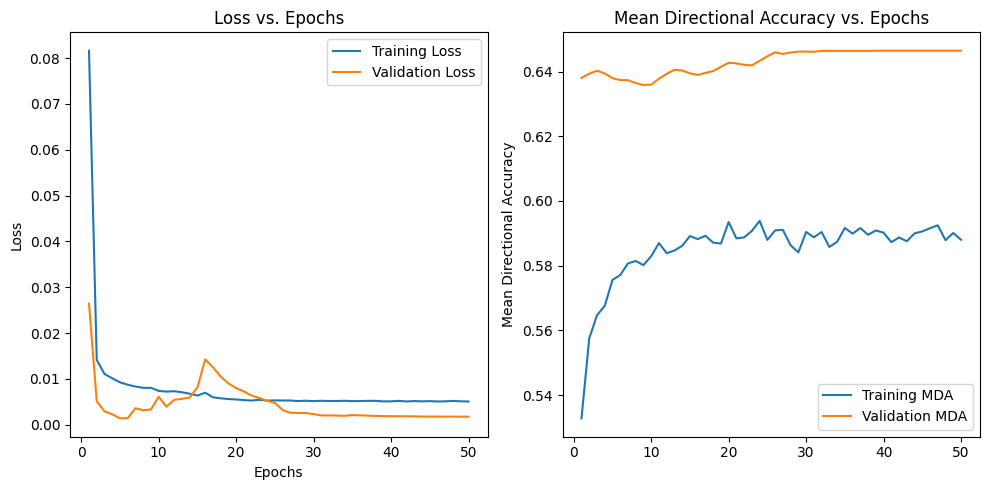

814/814 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


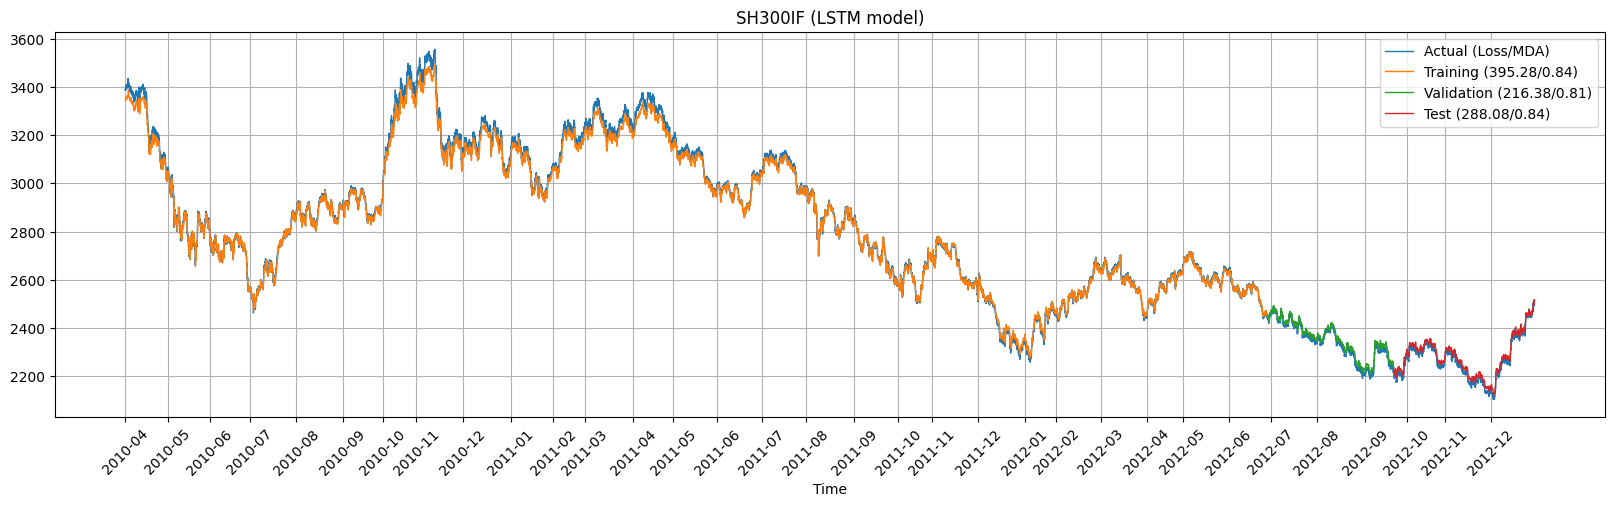

------------------------------------------------------------------------------------------------------



In [6]:
# Optimized window steps
# The ratio of time_steps and forecast_steps
windows = [
    (12,6,12), (12, 1, 12), (36, 1, 36)
]
RNN_pred_lst = []
GRU_pred_lst = []
LSTM_pred_lst = []

for window in windows:
    print(f"Window: time step = {window[0]}, forecast step = {window[1]}, window = {window[2]}")
    RNN_params['time_steps'] = window[0]
    RNN_params['forecast_steps'] = window[1]
    RNN_params['window'] = window[2]
    RNN_pred_lst.append(trainRNN(datasets_path[0], RNN_params))

    GRU_params['time_steps'] = window[0]
    GRU_params['forecast_steps'] = window[1]
    GRU_params['window'] = window[2]
    GRU_pred_lst.append(trainGRU(datasets_path[0], GRU_params))

    LSTM_params['time_steps'] = window[0]
    LSTM_params['forecast_steps'] = window[1]
    LSTM_params['window'] = window[2]
    LSTM_pred_lst.append(trainLSTM(datasets_path[0], LSTM_params))
    print("------------------------------------------------------------------------------------------------------")
    print()

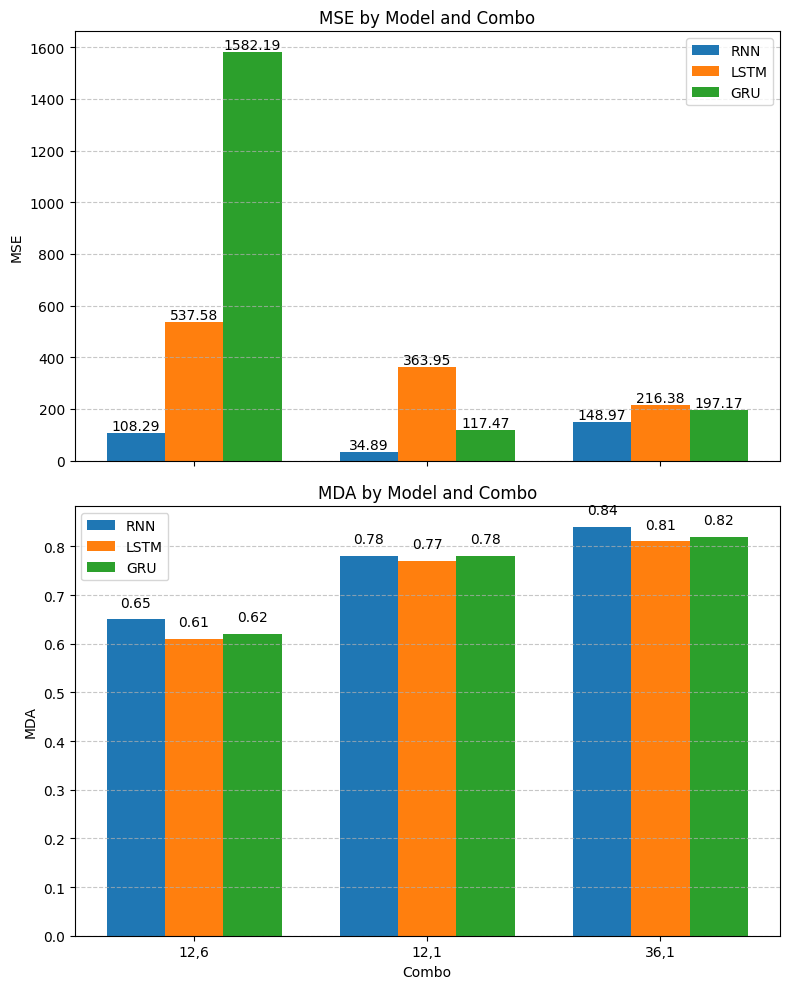

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Updated data
models = ['RNN', 'LSTM', 'GRU']
combos = ['12,6', '12,1', '36,1']
mse_data = [
    [108.29, 34.89, 148.97],   # RNN
    [537.58, 363.95, 216.38],  # LSTM
    [1582.19, 117.47, 197.17]  # GRU
]
mda_data = [
    [0.65, 0.78, 0.84],  # RNN
    [0.61, 0.77, 0.81],  # LSTM
    [0.62, 0.78, 0.82]   # GRU
]

# Define positions
x = np.arange(len(combos))  # Combo positions
width = 0.25                # Bar width

# Initialize the figure and axes
fig, axs = plt.subplots(2, 1, figsize=(8, 10), sharex=True)

# Function to annotate bars
def annotate_bars(ax, bars, values):
    for bar, value in zip(bars, values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height + 0.02, f'{value:.2f}',
                ha='center', va='bottom', fontsize=10)

# Plot MSE (Top)
for i, model in enumerate(models):
    bars = axs[0].bar(x + i * width, mse_data[i], width, label=model)
    annotate_bars(axs[0], bars, mse_data[i])
axs[0].set_title('MSE by Model and Combo')
axs[0].set_ylabel('MSE')
axs[0].legend()
axs[0].grid(axis='y', linestyle='--', alpha=0.7)

# Plot MDA (Bottom)
for i, model in enumerate(models):
    bars = axs[1].bar(x + i * width, mda_data[i], width, label=model)
    annotate_bars(axs[1], bars, mda_data[i])
axs[1].set_title('MDA by Model and Combo')
axs[1].set_ylabel('MDA')
axs[1].set_xlabel('Combo')
axs[1].legend()
axs[1].grid(axis='y', linestyle='--', alpha=0.7)

# Set x-ticks and labels
axs[1].set_xticks(x + width)
axs[1].set_xticklabels(combos)

# Adjust layout
plt.tight_layout()
plt.show()

Loading dataset... Ready for training.


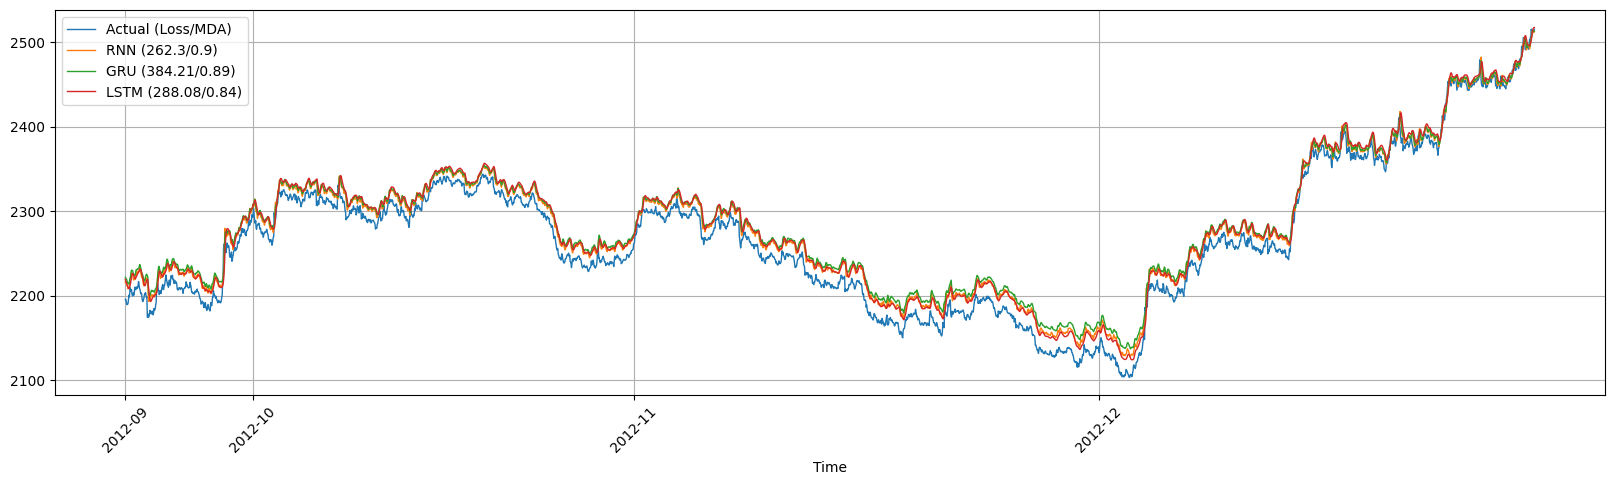

In [8]:
# Plot and compare the results obtained from the three RNNs on the test data set
RNNdata = StockIndexDataset(datasets_path[0], time_steps=RNN_params['time_steps'],
                            forecast_steps=RNN_params['forecast_steps'],
                            batch_size=RNN_params['batch_size'], val_ratio=.1, test_ratio=.1)

RNN_predictions = RNN_pred_lst[2]
GRU_predictions = GRU_pred_lst[2]
LSTM_predictions = LSTM_pred_lst[2]

testset = [RNN_predictions.true_org[2], 
           RNN_predictions.predictions_org[2],
           GRU_predictions.predictions_org[2],
           LSTM_predictions.predictions_org[2]]
datetime = pd.Series(RNNdata.datetime[2].values, 
                     index = RNN_predictions.true_org[2].index)
labels = ['Actual', 'RNN', 'GRU', 'LSTM']
list_mse = [RNN_predictions.loss[2],
       GRU_predictions.loss[2],
       LSTM_predictions.loss[2]]
list_mda = [RNN_predictions.mda[2],
       GRU_predictions.mda[2],
       LSTM_predictions.mda[2]]
labels_loss = create_labels(labels, list_mse, list_mda)
plot_seqs(testset, datetime=datetime, labels=labels_loss)

In [10]:
# Load previously saved models, including architecture, weights and optimizer states
dependencies = {'rmse': rmse,
                'mda': mda}
RNN_filepath = os.path.join(OUTPUT_PATH, "RNN_bestweights.keras")
saved_RNN = load_model(RNN_filepath, custom_objects=dependencies)

Loading dataset... Ready for training.
Stock Index Code: SH300IF
Test Set Length: (23136,)
723/723 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


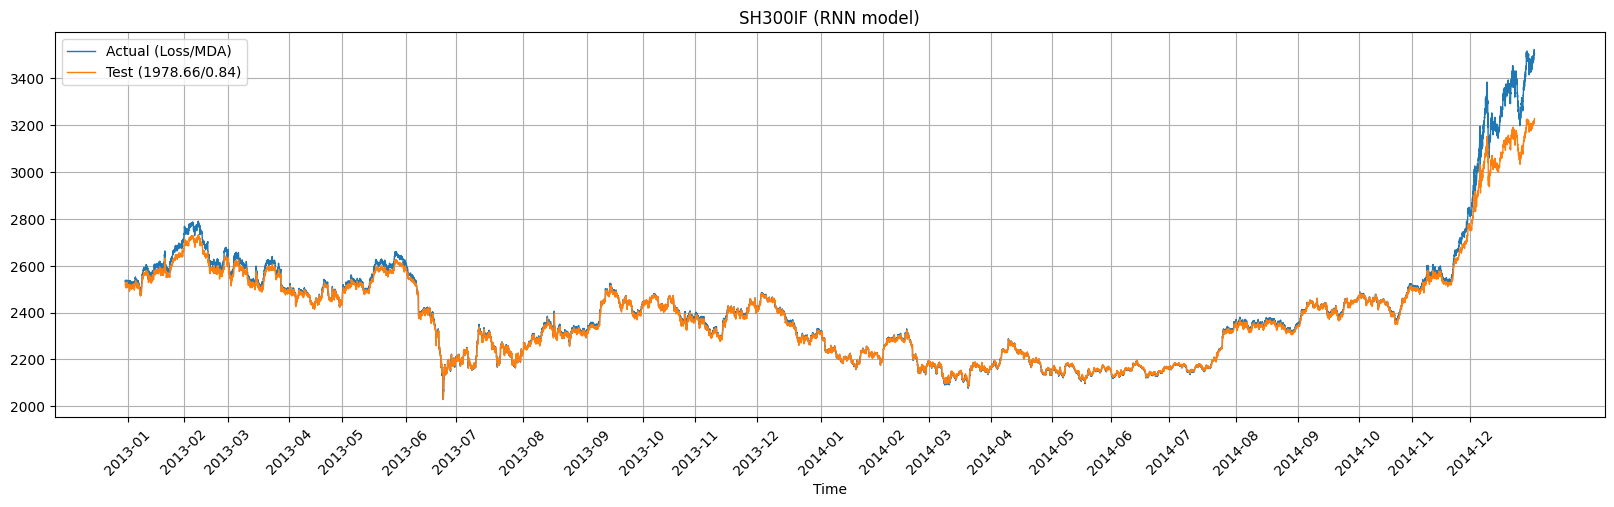

In [11]:
# Short-term

# Create a StockIndexDataset object that contains new data for testing the SimpleRNN network
# Create the object with the key "test_only=True"

test_data = StockIndexDataset(datasets_path[1], time_steps=RNN_params['time_steps'], 
                              forecast_steps=RNN_params['forecast_steps'],
                              batch_size=RNN_params['batch_size'], test_only=True)
test_data.info()
# Create a ModelPredictions object containing results of the Simple RNN model on the test data set 
RNN_test = ModelPredictions(saved_RNN, 
                            X = test_data.X, 
                            y = test_data.y, 
                            raw_y = test_data.raw_seq[:,1], 
                            datetime = test_data.datetime,
                            window = RNN_params['window'],
                            batch_size = RNN_params['batch_size'])

# Plot the testing results
labels = ['Actual', 'Test']
RNN_test.plot_predictions(title="SH300IF (RNN model)", labels=labels)

Loading dataset... Ready for training.
Stock Index Code: SH300IF
Test Set Length: (23296,)
728/728 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


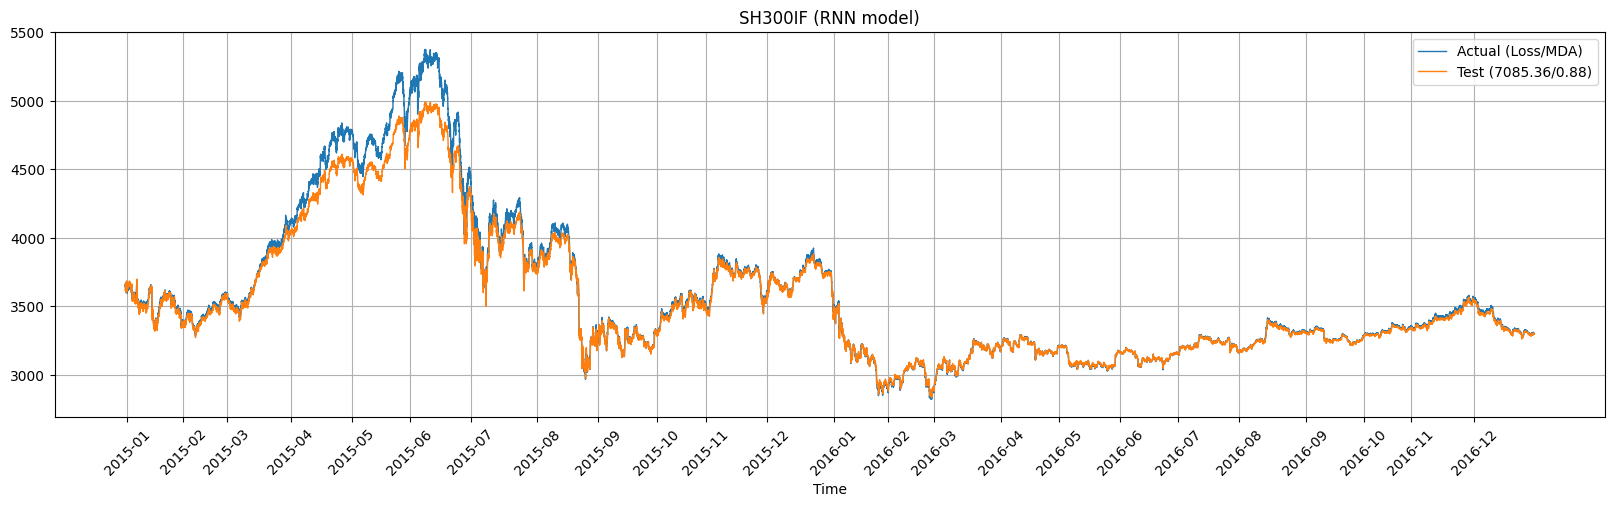

In [12]:
# Mid-term
test_data = StockIndexDataset(datasets_path[2], time_steps=RNN_params['time_steps'], 
                              forecast_steps=RNN_params['forecast_steps'],
                              batch_size=RNN_params['batch_size'], test_only=True)
test_data.info()
# Create a ModelPredictions object containing results of the Simple RNN model on the test data set 
RNN_test = ModelPredictions(saved_RNN, 
                            X = test_data.X, 
                            y = test_data.y, 
                            raw_y = test_data.raw_seq[:,1], 
                            datetime = test_data.datetime,
                            window = RNN_params['window'],
                            batch_size = RNN_params['batch_size'])

# Plot the testing results
labels = ['Actual', 'Test']
RNN_test.plot_predictions(title="SH300IF (RNN model)", labels=labels)

Loading dataset... Ready for training.
Stock Index Code: SH300IF
Test Set Length: (27040,)
845/845 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


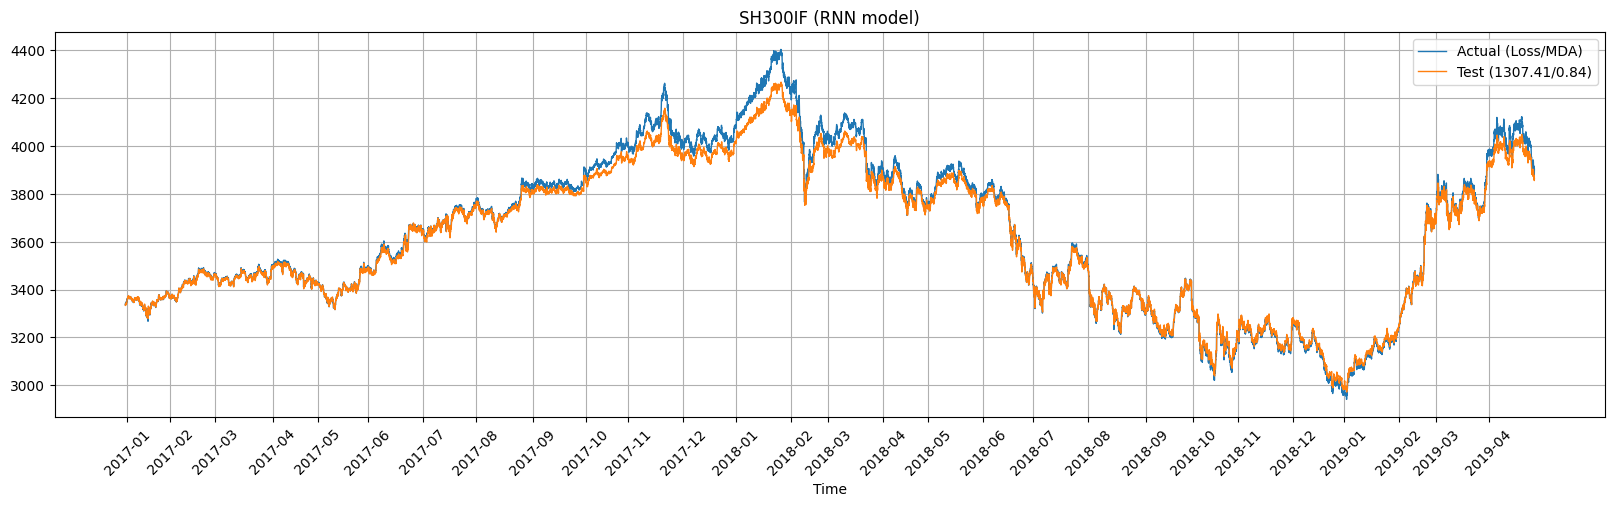

In [13]:
# Long-term
test_data = StockIndexDataset(datasets_path[3], time_steps=RNN_params['time_steps'], 
                              forecast_steps=RNN_params['forecast_steps'],
                              batch_size=RNN_params['batch_size'], test_only=True)
test_data.info()
# Create a ModelPredictions object containing results of the Simple RNN model on the test data set 
RNN_test = ModelPredictions(saved_RNN, 
                            X = test_data.X, 
                            y = test_data.y, 
                            raw_y = test_data.raw_seq[:,1], 
                            datetime = test_data.datetime,
                            window = RNN_params['window'],
                            batch_size = RNN_params['batch_size'])

# Plot the testing results
labels = ['Actual', 'Test']
RNN_test.plot_predictions(title="SH300IF (RNN model)", labels=labels)